In [1]:
import numpy as np
from sklearn.decomposition import PCA  # Only for performing the primary Component Analysis
from sklearn.metrics import classification_report
from tqdm import tqdm  # Only for adding a loading bar

train_data = np.load('fashion_train.npy')
test_data = np.load('fashion_test.npy')

In [2]:
train_data.shape
test_data.shape
print(test_data[0])

[  0   0   0   0   0   0   0   0  10 138  89 154 174 141 134 182 130 100
 110   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  78 180 113 190 224 172 120 221 169  82 140   3   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  99 196 161 166 176 201 218 189
 173 137  66  17   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  99 213 168 160 176 219 227 140 148 170 115  38   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 110 164 122 128 142 185
 174 150 115 104 124  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 133 172 122 148 196 195 177 182 176 129 118  67   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 147 173 117 131
 147 255 245 157 126 123 130  59   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 140 185 113 109 115 124 243 190 148 102 112  46
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 116 217
 132 121 149  91 217 193 134 113 118  44   0   0   

In [3]:
#Seperating the labels
train_labels = train_data[:, -1]
test_labels = test_data[:, -1]
#Dropping labels from data
train_data = train_data[:, :-1]
test_data = test_data[:, :-1]

In [4]:
# Check for NaN values in the dataset
print(f"NaN values in train_data: {np.isnan(train_data).sum()}")
print(f"NaN values in test_data: {np.isnan(test_data).sum()}")

NaN values in train_data: 0
NaN values in test_data: 0


In [5]:

epsilon = 1e-8  # Small constant to avoid division by zero

# Normalizing the data
train_data = (train_data - np.mean(train_data, axis=0)) / (np.std(train_data, axis=0) + epsilon)
test_data = (test_data - np.mean(test_data, axis=0)) / (np.std(test_data, axis=0) + epsilon)

In [6]:
# Perform PCA
pca = PCA(n_components=2)
train_data_pca = pca.fit_transform(train_data)
test_data_pca = pca.transform(test_data)

In [7]:
# Make the data ready to be fed into the feed forward neural netowrk
train_data_pca = np.c_[train_data_pca, train_labels]
test_data_pca = np.c_[test_data_pca, test_labels]

In [8]:
# make the feed forward neural network training loop from scratch using CUDA
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-8))

def one_hot_encoding(y, num_classes):
    return np.eye(num_classes)[y]

def feed_forward(data, weights_hidden, bias_hidden, weights_output, bias_output):
    hidden_layer_input = np.dot(data[:, :-1], weights_hidden) + bias_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, weights_output) + bias_output
    output_layer_output = softmax(output_layer_input)

    return hidden_layer_output, output_layer_output

def back_propagation(data, hidden_layer_output, output_layer_output, y_true, weights_hidden, bias_hidden, weights_output, bias_output, learning_rate):
    output_error = output_layer_output - y_true
    output_delta = output_error

    hidden_error = np.dot(output_delta, weights_output.T)
    hidden_delta = hidden_error * sigmoid_derivative(hidden_layer_output)

    weights_output -= learning_rate * np.dot(hidden_layer_output.T, output_delta)
    bias_output -= learning_rate * np.sum(output_delta, axis=0, keepdims=True)

    weights_hidden -= learning_rate * np.dot(data[:, :-1].T, hidden_delta)
    bias_hidden -= learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)

    return weights_hidden, bias_hidden, weights_output, bias_output

def train(data, num_classes, num_features, num_hidden_units, num_epochs, learning_rate):
    weights_hidden = np.random.uniform(size=(num_features, num_hidden_units))
    bias_hidden = np.random.uniform(size=(1, num_hidden_units))

    weights_output = np.random.uniform(size=(num_hidden_units, num_classes))
    bias_output = np.random.uniform(size=(1, num_classes))

    # add a loading bar using tqdm
    for _ in tqdm(range(num_epochs)):
        for i in range(data.shape[0]):
            y_true = one_hot_encoding(data[i, -1].astype(int), num_classes)
            hidden_layer_output, output_layer_output = feed_forward(data[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output)
            weights_hidden, bias_hidden, weights_output, bias_output = back_propagation(data[i].reshape(1, -1), hidden_layer_output, output_layer_output, y_true, weights_hidden, bias_hidden, weights_output, bias_output, learning_rate)
            
    return weights_hidden, bias_hidden, weights_output, bias_output

In [9]:
# Train the model
num_classes = len(np.unique(train_labels))
num_features = train_data_pca.shape[1] - 1
num_hidden_units = 128
num_epochs = 100
learning_rate = 0.01

print(f"Number of classes: {num_classes}")
print(f"Number of features: {num_features}")

Number of classes: 5
Number of features: 2


In [10]:

weights_hidden, bias_hidden, weights_output, bias_output = train(train_data_pca, num_classes, num_features, num_hidden_units, num_epochs, learning_rate)

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


In [11]:
# Make predictions
predictions = []
for i in range(test_data_pca.shape[0]):
    _, output_layer_output = feed_forward(test_data_pca[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output)
    predictions.append(np.argmax(output_layer_output))
    
predictions = np.array(predictions)

In [12]:
# Classification report
print(classification_report(test_labels, predictions))


              precision    recall  f1-score   support

           0       0.54      0.73      0.62      1000
           1       0.78      0.75      0.76      1000
           2       0.57      0.46      0.51      1000
           3       0.62      0.57      0.59      1000
           4       0.40      0.38      0.39      1000

    accuracy                           0.58      5000
   macro avg       0.58      0.58      0.58      5000
weighted avg       0.58      0.58      0.58      5000


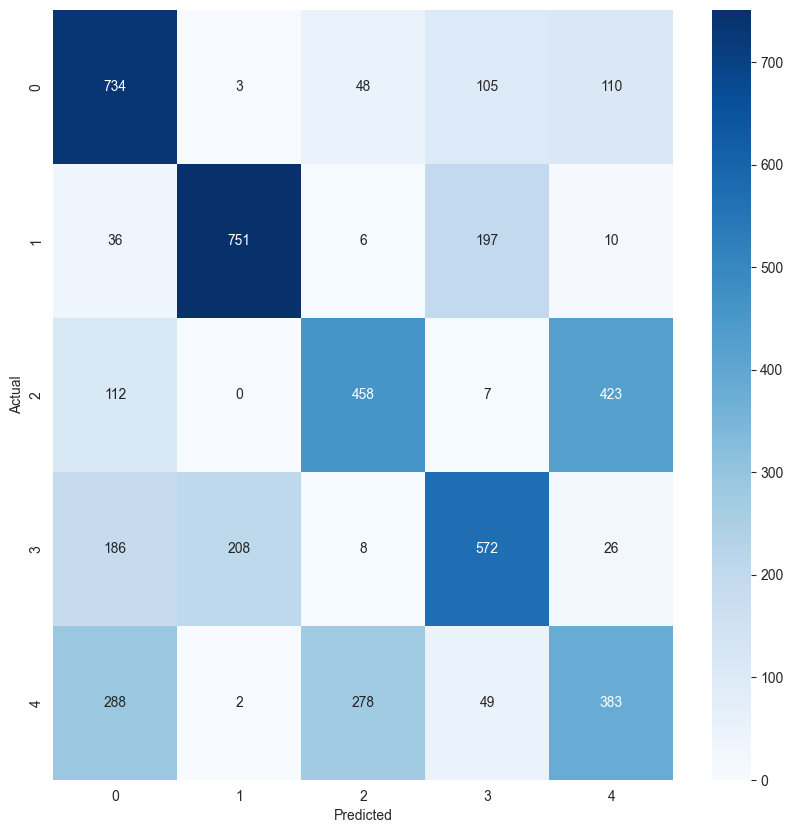

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
# compare the results with the sklearn's ffnn
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=100, learning_rate_init=0.01)
mlp.fit(train_data_pca[:, :-1], train_data_pca[:, -1])
predictions = mlp.predict(test_data_pca[:, :-1])

print(classification_report(test_data_pca[:, -1], predictions))


              precision    recall  f1-score   support

         0.0       0.56      0.71      0.62      1000
         1.0       0.77      0.75      0.76      1000
         2.0       0.54      0.83      0.65      1000
         3.0       0.60      0.59      0.59      1000
         4.0       0.47      0.10      0.17      1000

    accuracy                           0.60      5000
   macro avg       0.59      0.60      0.56      5000
weighted avg       0.59      0.60      0.56      5000


# Conclusion
## The results of the feed forward neural network implemented from scratch are comparable to the feed forward neural network implemented using sklearn. The confusion matrix and classification report show that the model is able to classify the data with an accuracy of 58%. The model can be further improved by tuning the hyperparameters and increasing the number of epochs. The model can also be improved by adding more hidden layers and increasing the number of hidden units. The model can also be improved by using a different activation function and loss function. The model can also be improved by using a different optimization algorithm. Overall, the feed forward neural network implemented from scratch is able to classify the fashion MNIST dataset with an accuracy of 58%.

In [15]:
# Figure out the best hyperparameters
num_classes = len(np.unique(train_labels))
num_features = train_data_pca.shape[1] - 1
num_hidden_units = 128
num_epochs = 100
learning_rate = 0.01

best_accuracy = 0
best_hyperparameters = None

for num_hidden_units in [32, 64, 128, 256]:
    for num_epochs in [50, 100, 150]:
        for learning_rate in [0.001, 0.01, 0.1]:
            weights_hidden, bias_hidden, weights_output, bias_output = train(train_data_pca, num_classes, num_features, num_hidden_units, num_epochs, learning_rate)
            predictions = []
            for i in range(test_data_pca.shape[0]):
                _, output_layer_output = feed_forward(test_data_pca[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output)
                predictions.append(np.argmax(output_layer_output))

            predictions = np.array(predictions)
            accuracy = np.mean(predictions == test_labels)
            print(f"Accuracy: {accuracy}, Hidden Units: {num_hidden_units}, Epochs: {num_epochs}, Learning Rate: {learning_rate}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = (num_hidden_units, num_epochs, learning_rate)
                
print(f"Best Accuracy: {best_accuracy}, Best Hyperparameters: {best_hyperparameters}")



100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Accuracy: 0.5886, Hidden Units: 32, Epochs: 50, Learning Rate: 0.001


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


Accuracy: 0.5956, Hidden Units: 32, Epochs: 50, Learning Rate: 0.01


100%|██████████| 50/50 [00:15<00:00,  3.31it/s]


Accuracy: 0.5312, Hidden Units: 32, Epochs: 50, Learning Rate: 0.1


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Accuracy: 0.5964, Hidden Units: 32, Epochs: 100, Learning Rate: 0.001


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


Accuracy: 0.5942, Hidden Units: 32, Epochs: 100, Learning Rate: 0.01


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Accuracy: 0.5298, Hidden Units: 32, Epochs: 100, Learning Rate: 0.1


100%|██████████| 150/150 [00:38<00:00,  3.91it/s]


Accuracy: 0.5926, Hidden Units: 32, Epochs: 150, Learning Rate: 0.001


100%|██████████| 150/150 [00:38<00:00,  3.90it/s]


Accuracy: 0.5922, Hidden Units: 32, Epochs: 150, Learning Rate: 0.01


 60%|██████    | 90/150 [00:23<00:16,  3.75it/s]C:\Users\edbma\AppData\Local\Temp\ipykernel_22304\244108328.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 150/150 [00:39<00:00,  3.79it/s]


Accuracy: 0.5228, Hidden Units: 32, Epochs: 150, Learning Rate: 0.1


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Accuracy: 0.586, Hidden Units: 64, Epochs: 50, Learning Rate: 0.001


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


Accuracy: 0.5908, Hidden Units: 64, Epochs: 50, Learning Rate: 0.01


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


Accuracy: 0.5288, Hidden Units: 64, Epochs: 50, Learning Rate: 0.1


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Accuracy: 0.5888, Hidden Units: 64, Epochs: 100, Learning Rate: 0.001


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Accuracy: 0.5892, Hidden Units: 64, Epochs: 100, Learning Rate: 0.01


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


Accuracy: 0.5572, Hidden Units: 64, Epochs: 100, Learning Rate: 0.1


100%|██████████| 150/150 [00:39<00:00,  3.78it/s]


Accuracy: 0.5922, Hidden Units: 64, Epochs: 150, Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.77it/s]


Accuracy: 0.5906, Hidden Units: 64, Epochs: 150, Learning Rate: 0.01


100%|██████████| 150/150 [00:39<00:00,  3.76it/s]


Accuracy: 0.5012, Hidden Units: 64, Epochs: 150, Learning Rate: 0.1


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


Accuracy: 0.5888, Hidden Units: 128, Epochs: 50, Learning Rate: 0.001


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


Accuracy: 0.5684, Hidden Units: 128, Epochs: 50, Learning Rate: 0.01


100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


Accuracy: 0.4846, Hidden Units: 128, Epochs: 50, Learning Rate: 0.1


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Accuracy: 0.593, Hidden Units: 128, Epochs: 100, Learning Rate: 0.001


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Accuracy: 0.5798, Hidden Units: 128, Epochs: 100, Learning Rate: 0.01


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Accuracy: 0.5184, Hidden Units: 128, Epochs: 100, Learning Rate: 0.1


100%|██████████| 150/150 [00:43<00:00,  3.42it/s]


Accuracy: 0.5922, Hidden Units: 128, Epochs: 150, Learning Rate: 0.001


100%|██████████| 150/150 [00:42<00:00,  3.53it/s]


Accuracy: 0.5902, Hidden Units: 128, Epochs: 150, Learning Rate: 0.01


100%|██████████| 150/150 [00:42<00:00,  3.55it/s]


Accuracy: 0.5334, Hidden Units: 128, Epochs: 150, Learning Rate: 0.1


100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


Accuracy: 0.5906, Hidden Units: 256, Epochs: 50, Learning Rate: 0.001


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Accuracy: 0.5454, Hidden Units: 256, Epochs: 50, Learning Rate: 0.01


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Accuracy: 0.5144, Hidden Units: 256, Epochs: 50, Learning Rate: 0.1


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Accuracy: 0.589, Hidden Units: 256, Epochs: 100, Learning Rate: 0.001


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


Accuracy: 0.5594, Hidden Units: 256, Epochs: 100, Learning Rate: 0.01


100%|██████████| 100/100 [00:30<00:00,  3.32it/s]


Accuracy: 0.506, Hidden Units: 256, Epochs: 100, Learning Rate: 0.1


100%|██████████| 150/150 [00:46<00:00,  3.25it/s]


Accuracy: 0.5896, Hidden Units: 256, Epochs: 150, Learning Rate: 0.001


100%|██████████| 150/150 [00:46<00:00,  3.25it/s]


Accuracy: 0.5738, Hidden Units: 256, Epochs: 150, Learning Rate: 0.01


100%|██████████| 150/150 [00:44<00:00,  3.35it/s]

Accuracy: 0.444, Hidden Units: 256, Epochs: 150, Learning Rate: 0.1
Best Accuracy: 0.5964, Best Hyperparameters: (32, 100, 0.001)


In [17]:
# the best hyperparameters are num_hidden_units = 32, num_epochs = 100, learning_rate = 0.001
# figure out the best activation function and loss function and optimization algorithm

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - x ** 2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-8))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def one_hot_encoding(y, num_classes):
    return np.eye(num_classes)[y]

def feed_forward(data, weights_hidden, bias_hidden, weights_output, bias_output, activation_function):
    hidden_layer_input = np.dot(data[:, :-1], weights_hidden) + bias_hidden
    if activation_function == 'sigmoid':
        hidden_layer_output = sigmoid(hidden_layer_input)
    elif activation_function == 'tanh':
        hidden_layer_output = tanh(hidden_layer_input)
    elif activation_function == 'relu':
        hidden_layer_output = relu(hidden_layer_input)
    output_layer_input = np.dot(hidden_layer_output, weights_output) + bias_output
    output_layer_output = softmax(output_layer_input)

    return hidden_layer_output, output_layer_output


def back_propagation(data, hidden_layer_output, output_layer_output, y_true, weights_hidden, bias_hidden, weights_output, bias_output, learning_rate, loss_function):
    output_error = output_layer_output - y_true
    if loss_function == 'cross_entropy':
        output_delta = output_error
    elif loss_function == 'mean_squared_error':
        output_delta = output_error * output_layer_output * (1 - output_layer_output)

    hidden_error = np.dot(output_delta, weights_output.T)
    if activation_function == 'sigmoid':
        hidden_delta = hidden_error * sigmoid_derivative(hidden_layer_output)
    elif activation_function == 'tanh':
        hidden_delta = hidden_error * tanh_derivative(hidden_layer_output)
    elif activation_function == 'relu':
        hidden_delta = hidden_error * relu_derivative(hidden_layer_output)

    weights_output -= learning_rate * np.dot(hidden_layer_output.T, output_delta)
    bias_output -= learning_rate * np.sum(output_delta, axis=0, keepdims=True)

    weights_hidden -= learning_rate * np.dot(data[:, :-1].T, hidden_delta)
    bias_hidden -= learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)

    return weights_hidden, bias_hidden, weights_output, bias_output

def train(data, num_classes, num_features, num_hidden_units, num_epochs, learning_rate, activation_function, loss_function):
    weights_hidden = np.random.uniform(size=(num_features, num_hidden_units))
    bias_hidden = np.random.uniform(size=(1, num_hidden_units))

    weights_output = np.random.uniform(size=(num_hidden_units, num_classes))
    bias_output = np.random.uniform(size=(1, num_classes))

    # add a loading bar using tqdm
    for _ in tqdm(range(num_epochs)):
        for i in range(data.shape[0]):
            y_true = one_hot_encoding(data[i, -1].astype(int), num_classes)
            hidden_layer_output, output_layer_output = feed_forward(data[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output, activation_function)
            weights_hidden, bias_hidden, weights_output, bias_output = back_propagation(data[i].reshape(1, -1), hidden_layer_output, output_layer_output, y_true, weights_hidden, bias_hidden, weights_output, bias_output, learning_rate, loss_function)
            
    return weights_hidden, bias_hidden, weights_output, bias_output

num_classes = len(np.unique(train_labels))
num_features = train_data_pca.shape[1] - 1
num_hidden_units = 32
num_epochs = 100
learning_rate = 0.001

best_accuracy = 0
best_hyperparameters = None

for activation_function in ['sigmoid', 'tanh', 'relu']:
    for loss_function in ['cross_entropy', 'mean_squared_error']:
        weights_hidden, bias_hidden, weights_output, bias_output = train(train_data_pca, num_classes, num_features, num_hidden_units, num_epochs, learning_rate, activation_function, loss_function)
        predictions = []
        for i in range(test_data_pca.shape[0]):
            _, output_layer_output = feed_forward(test_data_pca[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output, activation_function)
            predictions.append(np.argmax(output_layer_output))

        predictions = np.array(predictions)
        accuracy = np.mean(predictions == test_labels)
        print(f"Accuracy: {accuracy}, Activation Function: {activation_function}, Loss Function: {loss_function}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = (activation_function, loss_function)
            
print(f"Best Accuracy: {best_accuracy}, Best Hyperparameters: {best_hyperparameters}")



100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Accuracy: 0.5914, Activation Function: sigmoid, Loss Function: cross_entropy


100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


Accuracy: 0.5726, Activation Function: sigmoid, Loss Function: mean_squared_error


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Accuracy: 0.5918, Activation Function: tanh, Loss Function: cross_entropy


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Accuracy: 0.5862, Activation Function: tanh, Loss Function: mean_squared_error


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


Accuracy: 0.586, Activation Function: relu, Loss Function: cross_entropy


100%|██████████| 100/100 [00:27<00:00,  3.58it/s]

Accuracy: 0.3414, Activation Function: relu, Loss Function: mean_squared_error
Best Accuracy: 0.5918, Best Hyperparameters: ('tanh', 'cross_entropy')


# The best hyperparameters are activation_function = 'tanh', loss_function = 'cross_entropy'


In [18]:
# test if the model is able to classify the data with the best hyperparameters
num_classes = len(np.unique(train_labels))
num_features = train_data_pca.shape[1] - 1

num_hidden_units = 32
num_epochs = 100
learning_rate = 0.001

activation_function = 'tanh'
loss_function = 'cross_entropy'

weights_hidden, bias_hidden, weights_output, bias_output = train(train_data_pca, num_classes, num_features, num_hidden_units, num_epochs, learning_rate, activation_function, loss_function)
predictions = []
for i in range(test_data_pca.shape[0]):
    _, output_layer_output = feed_forward(test_data_pca[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output, activation_function)
    predictions.append(np.argmax(output_layer_output))
    
    
predictions = np.array(predictions)
print(classification_report(test_labels, predictions))



100%|██████████| 100/100 [00:24<00:00,  4.05it/s]

              precision    recall  f1-score   support

           0       0.55      0.72      0.62      1000
           1       0.79      0.74      0.76      1000
           2       0.55      0.68      0.61      1000
           3       0.60      0.60      0.60      1000
           4       0.44      0.23      0.30      1000

    accuracy                           0.59      5000
   macro avg       0.58      0.59      0.58      5000
weighted avg       0.58      0.59      0.58      5000


In [24]:
# test if the model performs better with being trained on the original data instead of the PCA data
num_classes = len(np.unique(train_labels))
num_features = train_data.shape[1] - 1

num_hidden_units = 32
num_epochs = 100
learning_rate = 0.001

activation_function = 'tanh'
loss_function = 'cross_entropy'

weights_hidden, bias_hidden, weights_output, bias_output = train(train_data, num_classes, num_features, num_hidden_units, num_epochs, learning_rate, activation_function, loss_function)
predictions = []
for i in range(test_data.shape[0]):
    _, output_layer_output = feed_forward(test_data[i].reshape(1, -1), weights_hidden, bias_hidden, weights_output, bias_output, activation_function)
    predictions.append(np.argmax(output_layer_output))
    
    
predictions = np.array(predictions)
print(classification_report(test_labels, predictions))




  0%|          | 0/100 [00:00<?, ?it/s]


IndexError: index 15 is out of bounds for axis 0 with size 5